# William Meynardie - STATS 507 Final Project

## Classifying Images of Animals Using the Vision Transformer

Note about usage of outside materials: much of the code to fine-tune the ViT model was borrowed liberally from the [tutorial](https://huggingface.co/blog/fine-tune-vit) on Hugging Face that uses the beans dataset.

Start by logging into Hugging Face.

In [3]:
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
notebook_login()

We begin by loading the dataset. We are using the "animals" dataset by the user "mertcobanov" on Hugging Face.

In [4]:
from datasets import load_dataset

ds = load_dataset('mertcobanov/animals', split='train')
ds

Resolving data files:   0%|          | 0/5400 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 5400
})

We divide a fifth of the images into a test dataset, and a fifth of the images into a validation dataset. The remaining 3/5 of the images are used for training.

In [5]:
split = ds.train_test_split(test_size=0.2, seed=42, stratify_by_column='label')

In [6]:
ds_train = split['train']
ds_test = split['test']
ds_train = ds_train.sort('label')
ds_test = ds_test.sort('label')

In [7]:
split_valid = ds_train.train_test_split(test_size=0.25, seed=42, stratify_by_column='label')
ds_valid = split_valid['test']
ds_train = split_valid['train']
ds_train = ds_train.sort('label')
ds_valid = ds_valid.sort('label')

We load up an example image and print the label and the image. The labels are just numbers, but each one maps to a different animal.

In [8]:
ex = ds_train[350]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=976x549>,
 'label': 9}

In [9]:
ex['label']

9

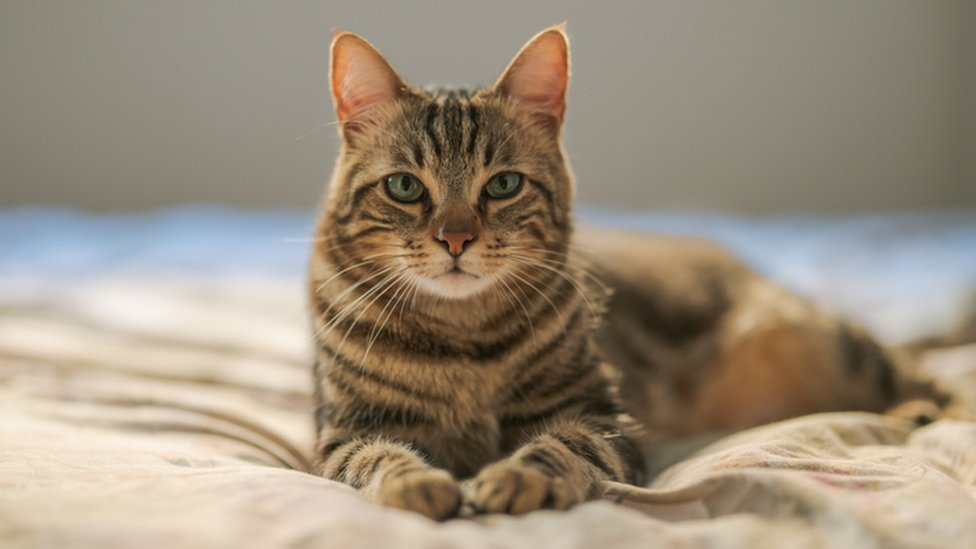

In [10]:
image = ex['image']
image

Aww, what a cutie.

Next we save all of the animal names to a variable called "labels". We test the int2str function, and find that the example we chose is a cat! We didn't need a machine to tell us that, but it's good to check.

In [11]:
labels = ds_train.features['label']
labels

ClassLabel(names=['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra'], id=None)

In [12]:
labels.int2str(ex['label'])

'cat'

In [13]:
label_names = ds_train.features['label'].names
len(label_names)

90

Here, we make an image with one example of every animal type, so we can get a better sense of all of the animals we're dealing with. There's 90 animal species in total in this dataset!

(This figure looks different than the one I submitted with my project proposal, because I wasn't splitting the dataset back then. The function I defined pulls the first animal of each species from the training dataset, but the training dataset is ordered differently now.)

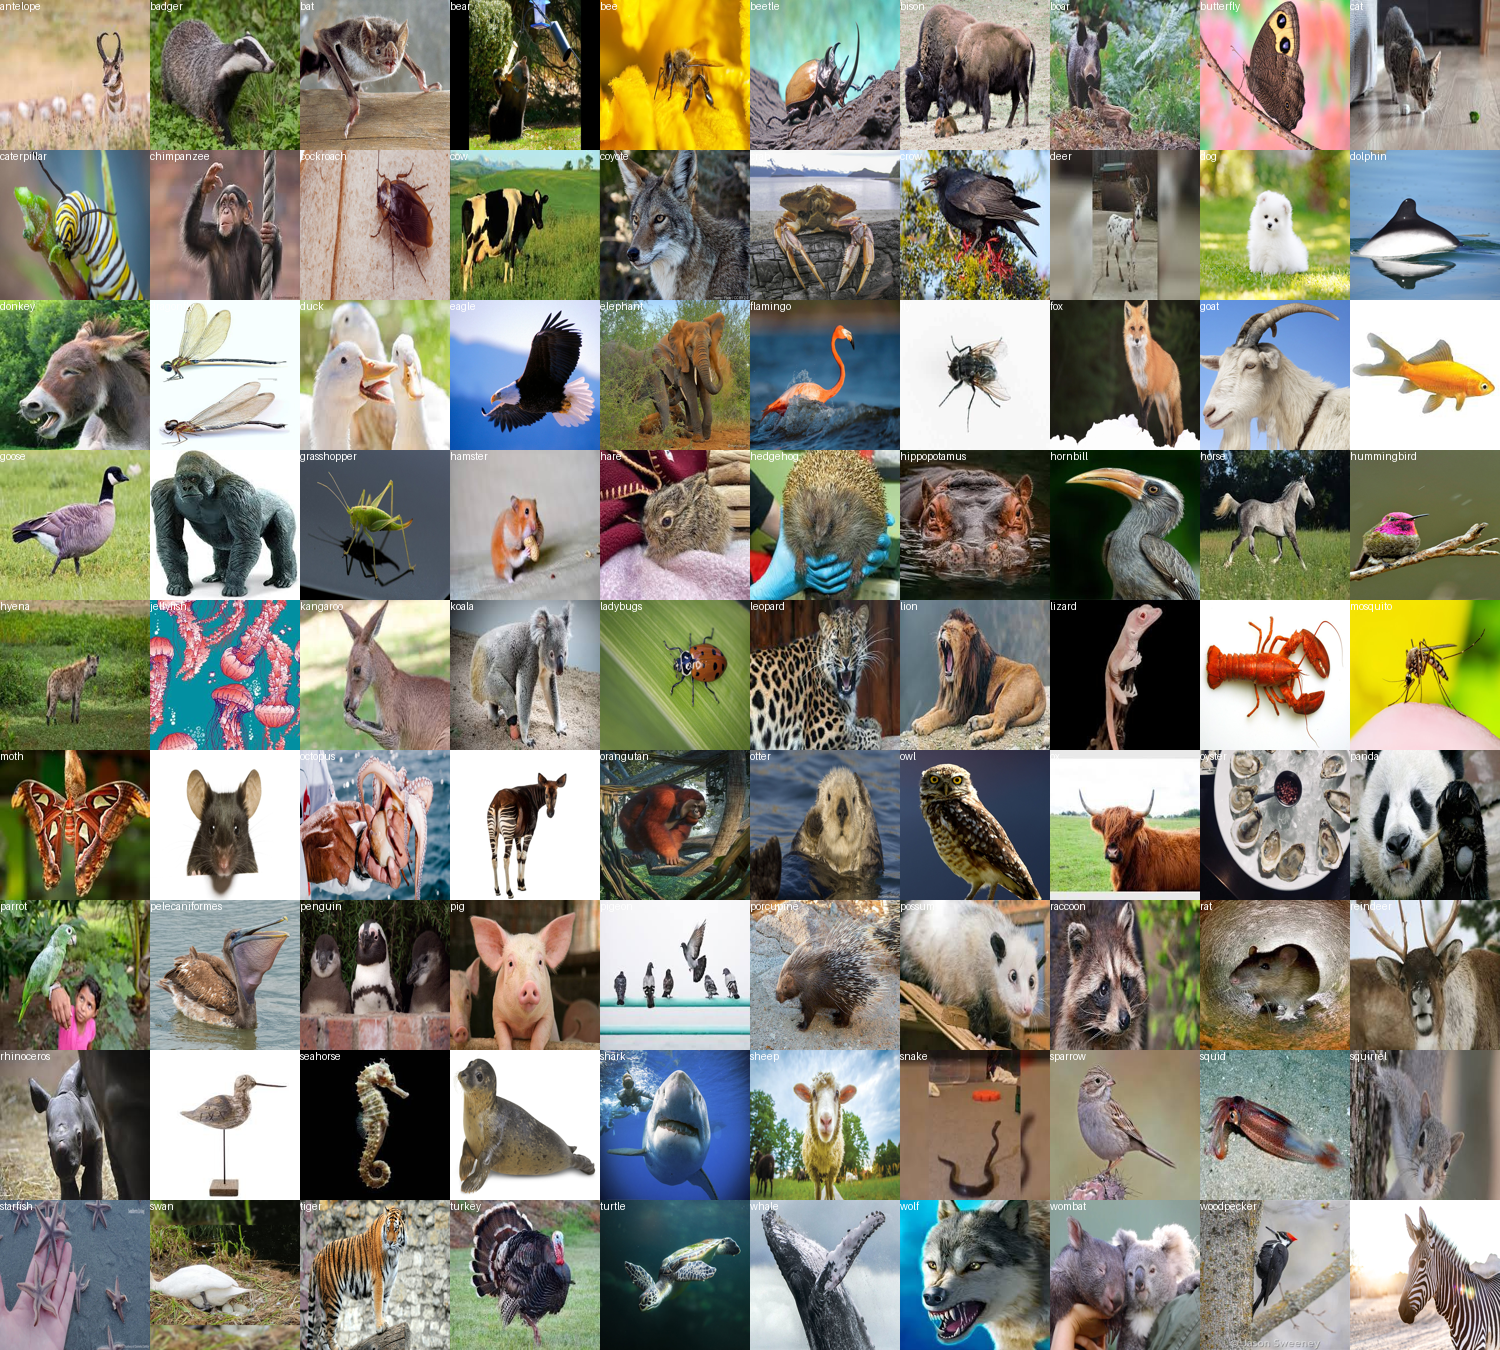

In [14]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, size=(150, 150)):

    w, h = size
    labels = ds_train.features['label'].names
    grid = Image.new('RGB', size=(10 * w, len(labels)//10 * h))
    draw = ImageDraw.Draw(grid)
    prev_idx = 0
    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        for i in range(len(ds_train)):
            if ds_train[i+prev_idx]['label'] == label_id:
                idx = i+prev_idx
                prev_idx = idx
                break

        # Plot this label's examples along a row
        #for i, example in enumerate(ds_slice):
        image = ds_train[idx]['image']
        box = (label_id % 10 * w, label_id // 10 * h)
        grid.paste(image.resize(size), box=box)
        draw.text(box, label, (255, 255, 255))

    return grid

show_examples(ds, seed=random.randint(0, 1337))

Now we load the ViTImageProcessor model.

In [15]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [16]:
print(processor)

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [17]:
processor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.0667,  0.0745,  0.0745,  ..., -0.1137, -0.1137, -0.1216],
          [ 0.0745,  0.0745,  0.0745,  ..., -0.1137, -0.1216, -0.1216],
          [ 0.0667,  0.0745,  0.0745,  ..., -0.1137, -0.1216, -0.1216],
          ...,
          [ 0.5843,  0.5765,  0.5608,  ...,  0.6235,  0.6235,  0.5922],
          [ 0.6078,  0.6078,  0.5922,  ...,  0.6235,  0.6157,  0.5922],
          [ 0.6235,  0.6235,  0.6078,  ...,  0.6078,  0.6078,  0.5843]],

         [[ 0.0353,  0.0431,  0.0431,  ..., -0.1373, -0.1373, -0.1451],
          [ 0.0431,  0.0431,  0.0431,  ..., -0.1373, -0.1451, -0.1451],
          [ 0.0353,  0.0431,  0.0431,  ..., -0.1373, -0.1451, -0.1451],
          ...,
          [ 0.4588,  0.4431,  0.4353,  ...,  0.5059,  0.4980,  0.4667],
          [ 0.4902,  0.4902,  0.4745,  ...,  0.4980,  0.4824,  0.4588],
          [ 0.5059,  0.5059,  0.4902,  ...,  0.4824,  0.4745,  0.4510]],

         [[-0.0588, -0.0510, -0.0510,  ..., -0.2549, -0.2549, -0.2627],
          [-0

Define the function that processes each of our images into a form readable by ViT.

In [18]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [19]:
process_example(ds_train[0])

{'pixel_values': tensor([[[[ 0.2706,  0.2784,  0.2863,  ...,  0.5137,  0.5373,  0.5373],
          [ 0.2863,  0.2863,  0.3020,  ...,  0.5059,  0.5294,  0.5373],
          [ 0.3098,  0.3098,  0.3176,  ...,  0.5059,  0.5216,  0.5294],
          ...,
          [ 0.4824,  0.4510,  0.4745,  ...,  0.3020,  0.3725,  0.4667],
          [ 0.6157,  0.4667,  0.4745,  ...,  0.3098,  0.3647,  0.4510],
          [ 0.5059,  0.4588,  0.5686,  ...,  0.3176,  0.3725,  0.4510]],

         [[ 0.1137,  0.1216,  0.1294,  ...,  0.2863,  0.3020,  0.3020],
          [ 0.1216,  0.1294,  0.1373,  ...,  0.2784,  0.2941,  0.3020],
          [ 0.1294,  0.1373,  0.1373,  ...,  0.2706,  0.2863,  0.2863],
          ...,
          [ 0.3647,  0.3333,  0.3569,  ...,  0.0902,  0.1373,  0.2157],
          [ 0.4902,  0.3333,  0.3333,  ...,  0.0980,  0.1216,  0.1922],
          [ 0.3569,  0.3020,  0.4118,  ...,  0.0902,  0.1137,  0.1922]],

         [[-0.1765, -0.1686, -0.1608,  ..., -0.0039,  0.0196,  0.0196],
          [-0

Define a function that transforms the datasets into a form readable by ViT.

In [20]:
# ds_train = load_dataset('mertcobanov/animals')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

In [21]:
prepared_train = ds_train.with_transform(transform)
prepared_test = ds_test.with_transform(transform)
prepared_valid = ds_valid.with_transform(transform)

In [22]:
prepared_train

Dataset({
    features: ['image', 'label'],
    num_rows: 3240
})

Next we define our data collater.

In [23]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Then we define our evaluation metric using the "accuracy" metric from the "evaluate" package.

In [24]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Here we load the pre-trained model.

In [25]:
from transformers import ViTForImageClassification

labels = ds_train.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now we define some of the TrainingArguments. We do not set fp16 to True because we were having issues running this on a Mac with fp16 set to True.

In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-animals",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=4,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


Now we define the Trainer. We use the training dataset and the validation dataset.

In [27]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_valid,
    tokenizer=processor,
)

/var/folders/2n/1mpvqxvj4nz5s3s80qwjttr40000gs/T/ipykernel_55475/3648052673.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Finally we're ready to train the model! WARNING: this can take between 30 minutes and an hour to run.

In [28]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

events.out.tfevents.1745246475.astro-wmeynard-mba.local:   0%|          | 0.00/28.5k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 936061413GF
  train_loss               =      0.9913
  train_runtime            =  0:40:38.20
  train_samples_per_second =       5.315
  train_steps_per_second   =       0.333


In [29]:
metrics = trainer.evaluate(prepared_valid)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9565
  eval_loss               =     0.2444
  eval_runtime            = 0:01:15.05
  eval_samples_per_second =     14.389
  eval_steps_per_second   =      1.799


In [30]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'mertcobanov/animals',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1745249009.astro-wmeynard-mba.local:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Now we test the model by trying to predict the test dataset.

In [31]:
outputs = trainer.predict(prepared_test)

In [32]:
id2label = {id: label for id, label in enumerate(ds_train.features['label'].names)}
label2id = {label: id for id, label in id2label.items()}

We generate a confusion matrix, but to be honest, this is a little hard to read because there's so many rows and columns.

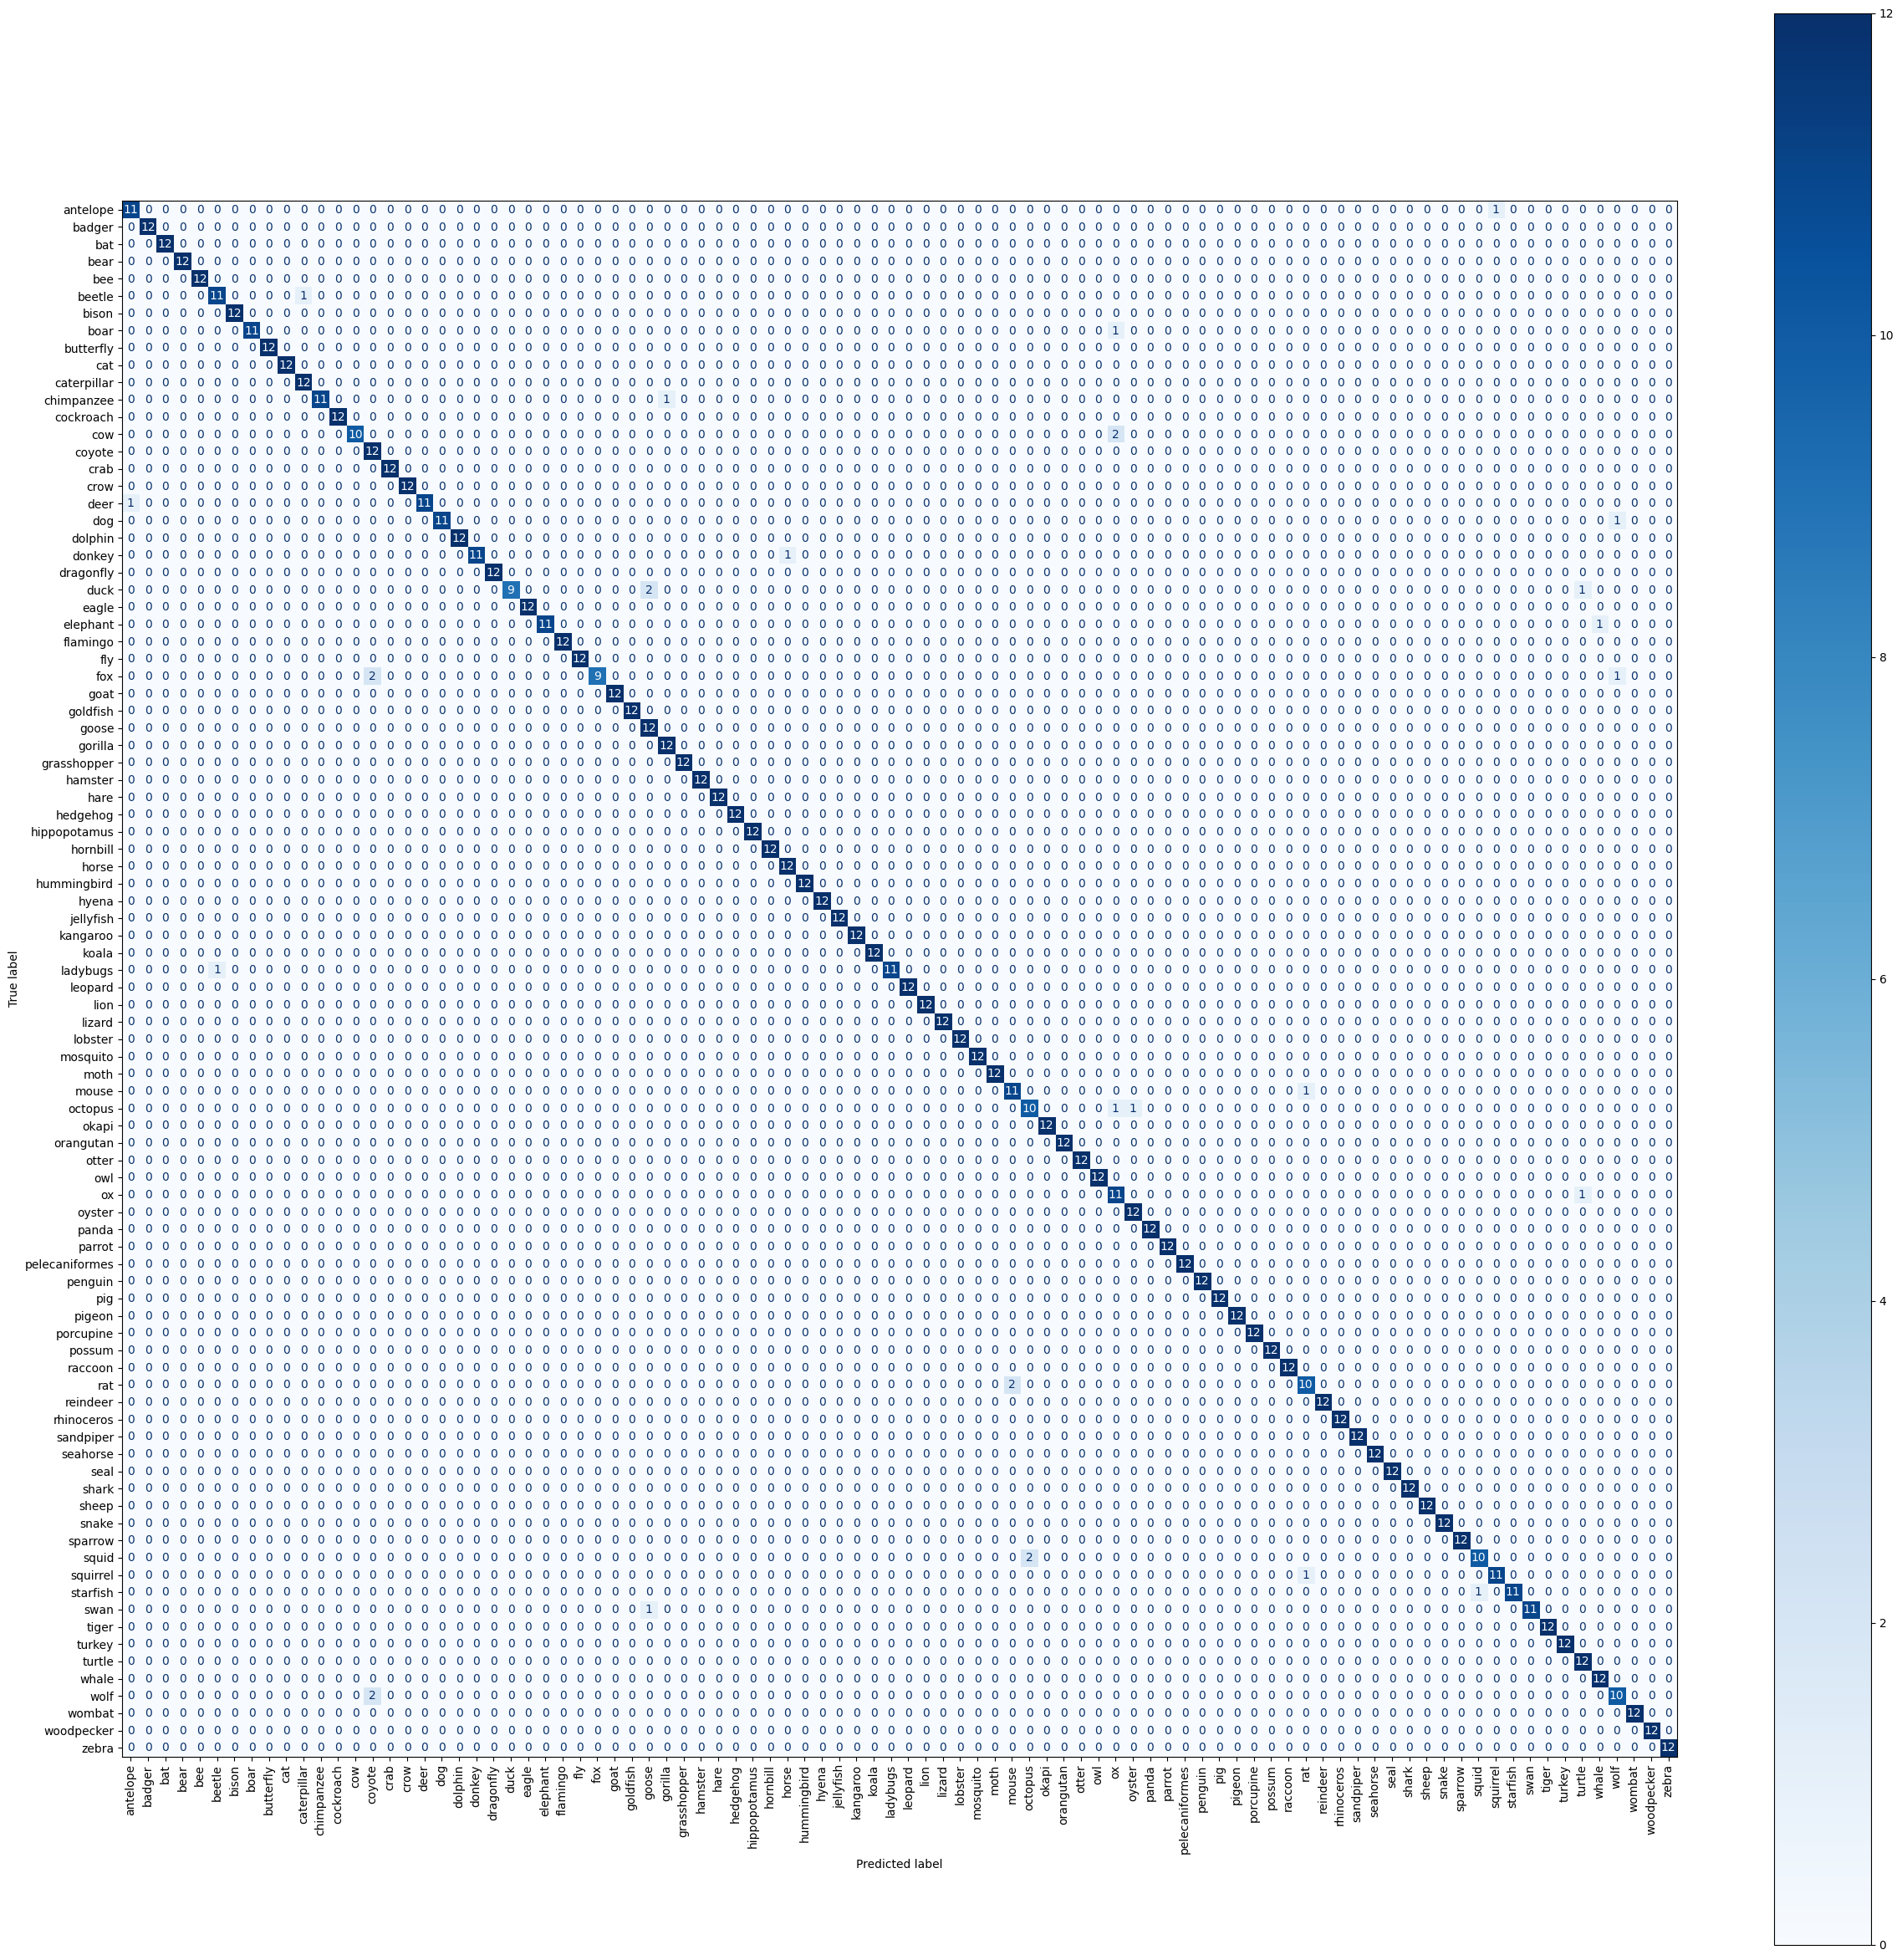

In [33]:
from sklearn.metrics import classification_report

target_names = id2label.values()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = ds_train.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(30, 30))
disp.plot(xticks_rotation=90, ax=ax, im_kw={'cmap': 'Blues'})
plt.savefig('confusion_matrix.pdf')

We decided it would probably be better to just show the results in a table, so this cell creates the LaTeX code for us.

In [34]:
correct = 0
amount = 0
toPrint = False
for i in range(y_pred.shape[0]):
    if y_true[i] == y_pred[i]:
        correct += 1
    amount += 1
    if amount == 12:
        if not toPrint:
            savestring = f'{id2label[y_true[i]].capitalize()} & {round(100*correct/amount)}\% & '
            toPrint = True
        elif toPrint:
            print(savestring + f'{id2label[y_true[i]].capitalize()} & {round(100*correct/amount)}\% \\\ \hline')
            toPrint = False
        amount = 0
        correct = 0

Antelope & 92\% & Badger & 100\% \\ \hline
Bat & 100\% & Bear & 100\% \\ \hline
Bee & 100\% & Beetle & 92\% \\ \hline
Bison & 100\% & Boar & 92\% \\ \hline
Butterfly & 100\% & Cat & 100\% \\ \hline
Caterpillar & 100\% & Chimpanzee & 92\% \\ \hline
Cockroach & 100\% & Cow & 83\% \\ \hline
Coyote & 100\% & Crab & 100\% \\ \hline
Crow & 100\% & Deer & 92\% \\ \hline
Dog & 92\% & Dolphin & 100\% \\ \hline
Donkey & 92\% & Dragonfly & 100\% \\ \hline
Duck & 75\% & Eagle & 100\% \\ \hline
Elephant & 92\% & Flamingo & 100\% \\ \hline
Fly & 100\% & Fox & 75\% \\ \hline
Goat & 100\% & Goldfish & 100\% \\ \hline
Goose & 100\% & Gorilla & 100\% \\ \hline
Grasshopper & 100\% & Hamster & 100\% \\ \hline
Hare & 100\% & Hedgehog & 100\% \\ \hline
Hippopotamus & 100\% & Hornbill & 100\% \\ \hline
Horse & 100\% & Hummingbird & 100\% \\ \hline
Hyena & 100\% & Jellyfish & 100\% \\ \hline
Kangaroo & 100\% & Koala & 100\% \\ \hline
Ladybugs & 92\% & Leopard & 100\% \\ \hline
Lion & 100\% & Lizard & 100\% \\

Overall, the model did very well at predicting the animals. But I'm really curious about the ox that it called a turtle...

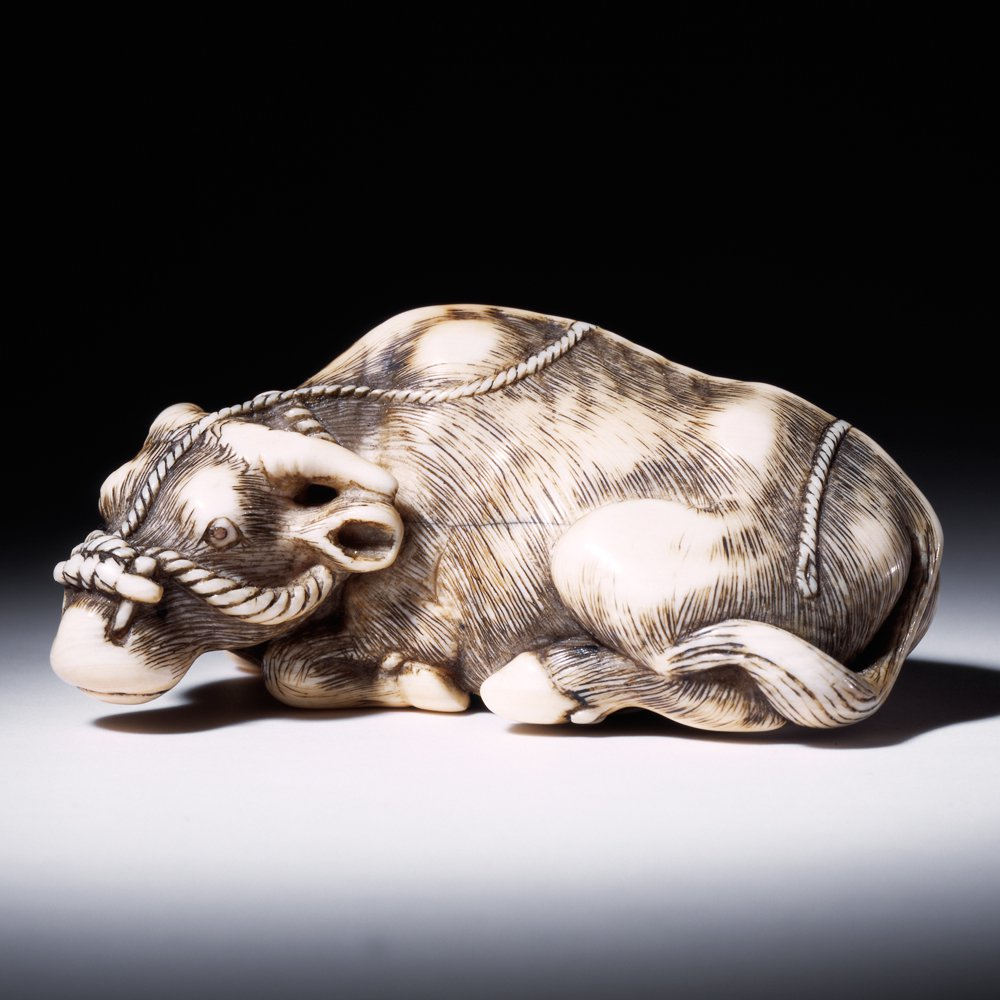

Total accuracy: 97.22222222222221


In [35]:
total_wrong = 0
for i in range(y_pred.shape[0]):
    if y_pred[i] != y_true[i]:
        total_wrong += 1
        # print(id2label[y_true[i]], id2label[np.argmax(outputs.predictions[i])])
    if id2label[y_true[i]] == 'ox' and id2label[np.argmax(outputs.predictions[i])] == 'turtle':
        display(ds_test[i]['image'])

print(f'Total accuracy: {100 * (1 - total_wrong / y_pred.shape[0])}')

Huh. I guess it does look like a turtle.